# Library imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import IntegratedGradients, Saliency, Occlusion

# Helper functions

In [2]:
# This simulates the ground truth model detailed in the methods section.
# The physics and assumptions of this model are detailed in the paper

def combined_ode_system(t,y,y0_g):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = ((0.74)* 10**-0.75)
    Kg = (0.2)* 10**2
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1
    
    Y_xg = (0.052)* 10**0
    
    m_k = (0.06)* 10**-2
    k_c_maint = (0.03)* 10**0    
    
    Y_mx = (20)* 10**-1
    beta = (5)* 10**-0.75
    
    kc = 10**1.5
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    mu_g = 2*((mu_g_max*Cg)/(Kg + Cg))
    
    Xm = Y_xg*y0_g
    
    log_x = (1-(Xv/Xm))
    
    mu_growth = mu_g*log_x
    
    mu_death = k_d + ((mu_c_death*Cc)/(Kc + Cc))/2
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    dXvdt = (mu_growth - mu_death)*Xv 
    
    dXddt = mu_death*Xv
    
    dCgdt = -1*(mu_growth/Y_xg)*Xv - maint_gc*Xv
    
    dCmdt = Y_mx*(mu_growth + beta)*Xv*(Cc/(Cc + kc))
    
    dCcdt = -1*dCmdt
    
    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]

In [3]:
y0 = np.array([0.1, 0.0, 82, 0, 20])
tspan = (0, 72)

sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau")

y_true = np.copy(sol.y)

y_act = sol.y
y_act[0,:] = y_act[0,:] + y_act[1,:]
y_act1 = np.delete(y_act, 1, axis = 0)

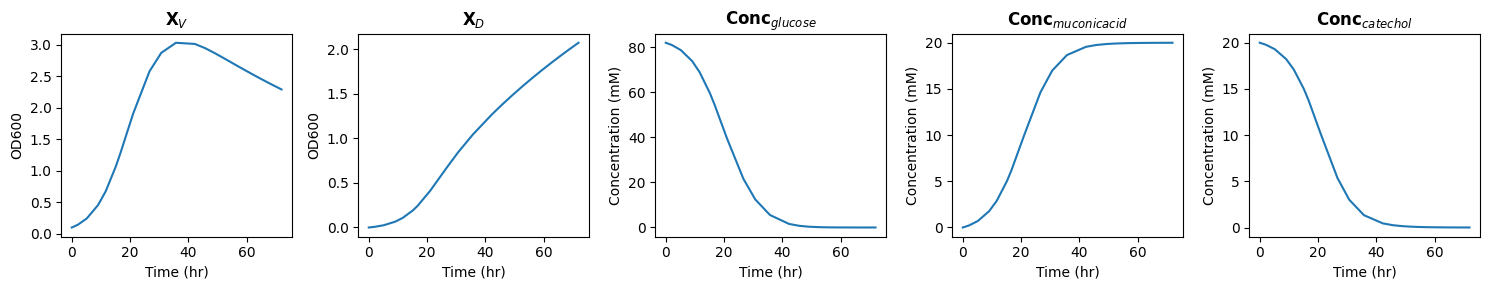

In [4]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

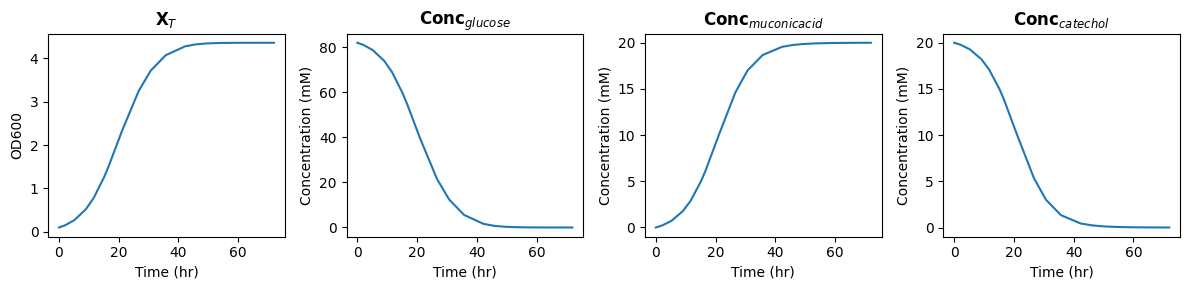

In [5]:
fig, axs = plt.subplots(1, 4, figsize = (12, 3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

In [6]:
def syn_data_generation(num_points, file_name):
    
    # This function takes in the number point and a file name which has
    # different initial conditions of the batch system. This generates 
    # the training data outlined in the paper. 72-hour batch bioprocess.
    # This return the training data 
    
    dir_n = "Initial_conditions\\" + file_name
    
    Init_cond = np.loadtxt(dir_n)

    sol_dict = {}
    mu_dict = {}

    for i in range(len(Init_cond)):
        
        y0 = Init_cond[i,:]
        tspan = (0, 72)
        teval = np.linspace(tspan[0], tspan[1], num_points)
        
        sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau", t_eval = teval)
        
        y_act = sol.y
        y_act[0,:] = y_act[0,:] + y_act[1,:]
        y_act = np.delete(y_act, 1, axis = 0)
        
        sol_dict[i] = y_act
        
        time = sol.t
    
    return [time, sol_dict]

In [7]:
def Error_addition(num_points, file_name, per_err, rs = 10):
    
    # This function adds gaussian noise to the training data
    # This calls the previous function and then adds error to it
    # This function returns the error-added training data
    
    random_seed = rs
    
    time, s_dict = syn_data_generation(num_points, file_name)    
    num_sp, num_t = np.shape(s_dict[0])

    retreived_conc_dict = {}

    for i in range(len(s_dict.keys())):
        
        np.random.seed(random_seed+i)
        D_err = np.random.normal(0,per_err,size = (num_sp, num_t))/100
        
        conc_profiles = s_dict[i]
        D_final = conc_profiles + np.multiply(conc_profiles, D_err)

        retreived_conc_dict[i] = D_final

    
    return [time, retreived_conc_dict]

In [8]:
file_name = "Initial_conditions_3_1_PP.txt"
time, s = syn_data_generation(10, file_name)
t, rc = Error_addition(10,file_name, 10, rs = 5)

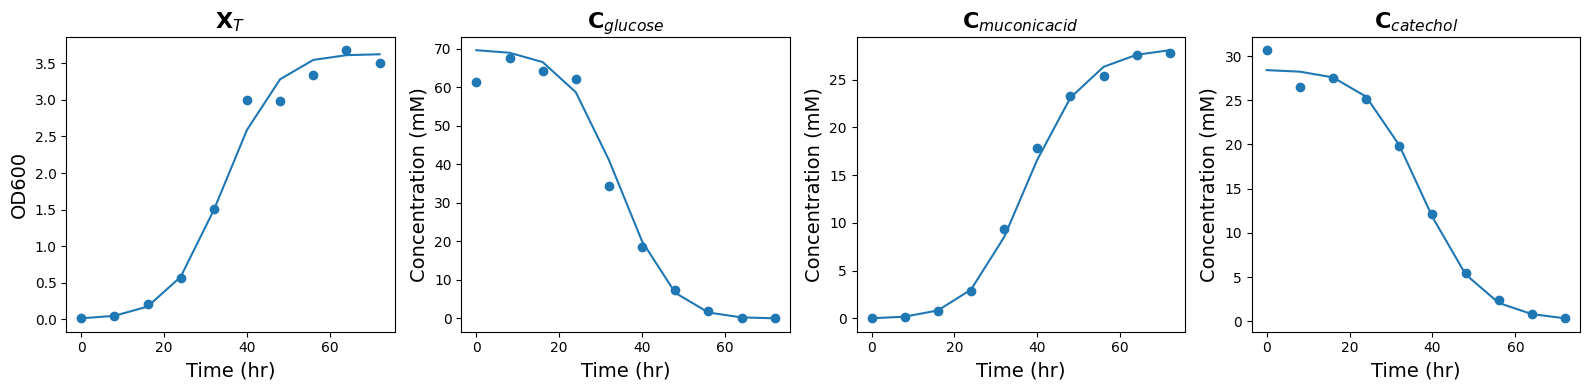

In [9]:
i = 0

fig, axs = plt.subplots(1,4,figsize = (16,4))
ax = axs.ravel()
Name = ["X$_T$", "C$_{glucose}$", "C$_{muconic acid}$", "C$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for j in range(4):
    ax[j].plot(time, s[i][j])
    ax[j].scatter(t, rc[i][j])
    ax[j].set_xlabel("Time (hr)", fontsize = 14)
    ax[j].set_ylabel(ylabels[j], fontsize = 14)
    ax[j].set_title(Name[j], fontweight = "bold", fontsize = 16)

plt.tight_layout()

# Integrated Model Construction

In [10]:
def ANN_int_mu_model(model,d,t):
    
    # This is the integrated ANN model
    # which will be embedded within the pyomo formulation
    
    Xt = model.conc_Xt[d,t]
    Cg = model.conc_Cg[d,t]
    Cm = model.conc_Cm[d,t]
    Cc = model.conc_Cc[d,t]
    
    h1_list = []
    
    # This calculates the first layer 
    for i in model.h1_num_nod:
        z1 = model.W1[0,i]*Xt + model.W1[1,i]*Cg + model.W1[2,i]*Cm + model.W1[3,i]*Cc + model.b1[i]
        h1 = (1/(1 + math.e**(-1*z1))) #(math.e**(2*z1) - 1)/(math.e**(2*z1) + 1)
        h1_list.append(h1)
    
    z2 = model.b2
    for i in model.h1_num_nod:
        z2 += model.W2[i]*h1_list[i]
    h3 = z2
    
    return h3

In [11]:
def dXtdt_int_con(model, d, t):
    # This captures the ODE dynamic equation for total biomass dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dXtdt[d,t] == mu*model.conc_Xt[d,t]

def dCgdt_int_con(model,d,t):
    # This captures the ODE dynamic equation for glucose concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dCgdt[d,t] == -1*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_int_con(model,d,t):
    # This capture the ODE dynamic equations for muconic acid concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_int_con(model,d,t):
    # This captures the ODE dynamic equations for catechol concentration dynamics
    if t == 0:
        return Constraint.Skip
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_int_SSmse(model):
    # This is a state space objective function for the integrated model
    final = 0
    
    for i in model.d_idx:
        for j in model.t_meas:
            final += (model.conc_Xt_meas[i,j] - model.conc_Xt[i,j])**2
            final += (model.conc_Cg_meas[i,j] - model.conc_Cg[i,j])**2
            final += (model.conc_Cm_meas[i,j] - model.conc_Cm[i,j])**2
            final += (model.conc_Cc_meas[i,j] - model.conc_Cc[i,j])**2
    
    fin = final/(4*len(model.d_idx)*len(model.t_meas))
    
    return fin

In [12]:
def make_model_int_rs_fl(rs, fl):
    
    # This utilizes the above training data generating functions
    # to generate 10-points per initial condition at 10% gaussian noise
    # The initial condition file name and random seed is specified.
    
    num = 10
    err = 10
    rs = rs

    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []

    for i in range(3):
        y_temp.append(rc[i])

    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(no_touch_y)

    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis = 0), axis = 1)

    y_scaled = np.zeros(np.shape(y_temp))
    
    # The training data is converted from numpy files to dictionary
    # This is so that it can be utilized in pyomo formulation

    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j,t[i])] = y_temp[j,0,i]/max_vals[0]
            y_scaled[j,0,i] = y_temp[j,0,i]/max_vals[0]

            Cg_dict[(j,t[i])] = y_temp[j,1,i]/max_vals[1]
            y_scaled[j,1,i] = y_temp[j,1,i]/max_vals[1]

            Cm_dict[(j,t[i])] = y_temp[j,2,i]/max_vals[2]
            y_scaled[j,2,i] = y_temp[j,2,i]/max_vals[2]

            Cc_dict[(j,t[i])] = y_temp[j,3,i]/max_vals[3]
            y_scaled[j,3,i] = y_temp[j,3,i]/max_vals[3]
            
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # The number of nodes is setup and the following pyomo formulation was generated
    
    num_nodes = 1

    model = ConcreteModel()

    # Sets describing the raw dataset
    model.d_idx = Set(initialize = range(n_d))
    model.t_meas = Set(initialize = no_touch_t)

    # Sets and Param describing integrated ANN structure
    model.h1_num_nod = Set(initialize = range(num_nodes))
    model.num_inputs = Set(initialize = range(n_s))

    # Parameters - State Space data measurment
    model.max_vals = Param(range(4), initialize = max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize = Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize = Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize = Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize = Cc_dict)

    # Variables - Time invariant Parameters
    model.Ygx = Var(within = NonNegativeReals)
    model.Ymx = Var(within = NonNegativeReals)
    model.beta = Var(within = NonNegativeReals)
    model.kc = Var(within = NonNegativeReals)

    # Variables - Concentrations and derivatives
    model.time = ContinuousSet(initialize = model.t_meas, bounds = (0,72))

    model.conc_Xt = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within = NonNegativeReals)

    model.dXtdt = DerivativeVar(model.conc_Xt, within = Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within = Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within = Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within = Reals)

    # Variables - ANN weights and biases
    model.W1 = Var(model.num_inputs, model.h1_num_nod, bounds = (-1,1))
    model.b1 = Var(model.h1_num_nod, bounds = (-1,1))
    model.W2 = Var(model.h1_num_nod, bounds = (-1,1))
    model.b2 = Var(bounds = (-1,1))

    # Constraints - Hybrid ODEs
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule = dXtdt_int_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule = dCgdt_int_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule = dCmdt_int_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule = dCcdt_int_con)

    # Objective - State space MSE
    model.obj = Objective(expr = objective_int_SSmse)

    # Descritizer for pyomo.dae
    discretizer = TransformationFactory('dae.collocation')

    discretizer.apply_to(model,nfe=n_t,
                         ncp=2,
                         scheme='LAGRANGE-RADAU')

    # Solver - multistart
    solver = SolverFactory("multistart")
    results = solver.solve(model,
                           suppress_unbounded_warning = True,
                           iterations = 50)

    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))
    
    # This function returns the pyomo formulation model and the max values to perform
    # a max-scaling of the training data and other testing data
    return [max_vals, model]

In [13]:
def TIV_and_ANN_int_params(model):
    
    # This function takes in a integrated pyomo model
    # and it extracts the time invariant parameters and
    # the ANN weights and biases
    
    TIV_params = {}

    TIV_params["Ygx"] = value(model.Ygx)
    TIV_params["Ymx"] = value(model.Ymx)
    TIV_params["beta"] = value(model.beta)
    TIV_params["kc"] = value(model.kc)
    
    ANN_params = {}

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    W1 = np.zeros((len(model.num_inputs), len(model.h1_num_nod)))
    b1 = np.zeros((len(model.h1_num_nod),1))
    W2 = np.zeros((len(model.h1_num_nod),1))

    for i in model.num_inputs:
        for j in model.h1_num_nod:
            W1[i,j] = value(model.W1[i,j])

    for i in model.h1_num_nod:
        b1[i] = value(model.b1[i])
        W2[i] = value(model.W2[i])

    ANN_params["W1"] = W1
    ANN_params["b1"] = b1
    ANN_params["W2"] = W2
    ANN_params["b2"] = value(model.b2)
    
    return [TIV_params, ANN_params]

In [14]:
def Xy_dataset(model):
    
    X = []
    y = []

    for i in model.d_idx:
        for j in model.t_meas:
            tempX = np.array([value(model.conc_Xt_meas[i,j]),
                    value(model.conc_Cg_meas[i,j]),
                    value(model.conc_Cm_meas[i,j]),
                    value(model.conc_Cc_meas[i,j])
                   ])
            X.append(tempX)
            y.append(value(ANN_int_mu_model(model, i,j)))

    X = np.array(X)
    y = np.array(y)
    
    return [X, y]

## Integrated model assembly and testing

In [15]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_5_PP.txt"]

ANN_comp_dict = {}
Xy_comp_dict = {}

for fl in range(len(file_list)):
    
    print(file_list[fl])
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs]+1, file_list[fl])

        tdict, adict = TIV_and_ANN_int_params(model_rs1)
        ANN_comp_dict[file_list[fl] + str(random_seed_list[rs])] = adict
        
        X, y = Xy_dataset(model_rs1)
        Xy_comp_dict[file_list[fl] + str(random_seed_list[rs])] = [X,y]

        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_5_PP.txt
Solver status: ok
Termination Condition: optimal
0.0022929733567601173
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0018340065454439673
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.002231208530867208
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0029109463433550126
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0031771005795651645
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [16]:
X_comp_dict = {}
y_comp_dict = {}

for i in list(Xy_comp_dict.keys()):
    X_comp_dict[i] = Xy_comp_dict[i][0]
    y_comp_dict[i] = Xy_comp_dict[i][1]

# ANN interpretation

In [17]:
ANN_dict = ANN_comp_dict
X_dict = X_comp_dict
y_dict = y_comp_dict

In [18]:
tempk = list(ANN_dict.keys())[0]
ANN_dict[tempk]

{'W1': array([[ 0.09646305],
        [-0.99998439],
        [-0.08794791],
        [ 0.1792697 ]]),
 'b1': array([[0.1078342]]),
 'W2': array([[-0.9999839]]),
 'b2': 0.5290798262270773}

In [19]:
ANN_recon_dict = {}

for i in list(ANN_dict.keys()):
    temp_dict = {}
    
    model = nn.Sequential(
        nn.Linear(4,1),
        nn.Tanh(),
        nn.Linear(1,1))
    
    ANN_params = ANN_dict[i]
    
    with torch.no_grad():
        model[0].weight.copy_(torch.from_numpy(ANN_params["W1"].T))
        model[0].bias.copy_(torch.from_numpy(ANN_params["b1"].reshape(1,)))
        model[2].weight.copy_(torch.from_numpy(ANN_params["W2"].T))
        model[2].bias.copy_(torch.from_numpy(np.array([ANN_params["b2"]]).reshape(1,)))
    
    temp_dict["ANN"] = model
    temp_dict["X"] = torch.tensor(X_dict[i], dtype = torch.float32)
    
    ANN_recon_dict[i] = temp_dict

## ANN Interpretation - Training Data

In [20]:
performance_dict = {}
keys = list(ANN_recon_dict.keys())

for i in range(len(keys)):
    temp_dict = {}
    ANN_model = ANN_recon_dict[keys[i]]["ANN"]
    X = ANN_recon_dict[keys[i]]["X"]
    
    ig = IntegratedGradients(ANN_model)
    attr_ig, delta_ig = ig.attribute(X, return_convergence_delta = True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    igs = attr_ig.detach().numpy()
    
    temp_dict["IGs"] = igs
    
    performance_dict[keys[i]] = temp_dict

In [24]:
ig_fl = []
X_fl = []

for i in range(len(keys)):
    td = performance_dict[keys[i]]["IGs"]
    X = ANN_recon_dict[keys[i]]["X"].detach().numpy()
    
    ig_fl.append(td)
    X_fl.append(X)
    
ig_fl = np.array(ig_fl)
ig_ICs = []

i = 0
temp = np.mean(ig_fl[5*i:5*(i+1), :, :], axis = 0)
ig_ICs.append(temp)
ig_ICs = np.array(ig_ICs)

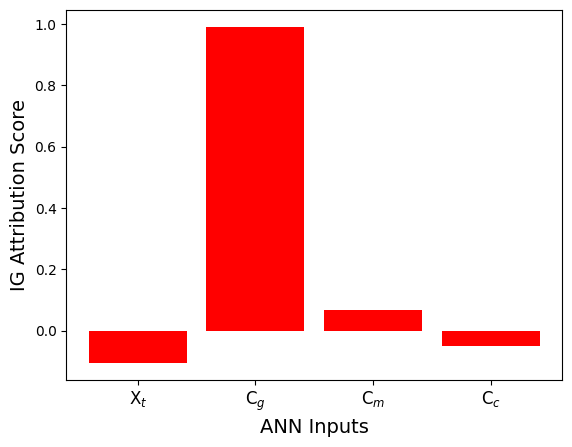

In [27]:
ig_mean = np.mean(ig_ICs[0,:,:], axis = 0)
ig_norm = ig_mean/np.linalg.norm(ig_mean)

x = 0.12*np.arange(1,5)
w = 0.1
color = ["r", "b", "y"]
plt.bar(x, ig_norm, label = "Integrated Gradeints", width = w, color = "red")
plt.ylabel("IG Attribution Score", fontsize = 14)
plt.xlabel("ANN Inputs", fontsize = 14)
plt.xticks(ticks = x, labels = ["X$_t$", "C$_g$","C$_m$","C$_c$"], fontsize = 12)
#plt.legend()
#plt.savefig("ann_att.svg")
plt.show()

In [28]:
X_fl = np.vstack(X_fl)
Ig_fl = np.vstack(ig_fl)

x_temp = X_fl
a = Ig_fl

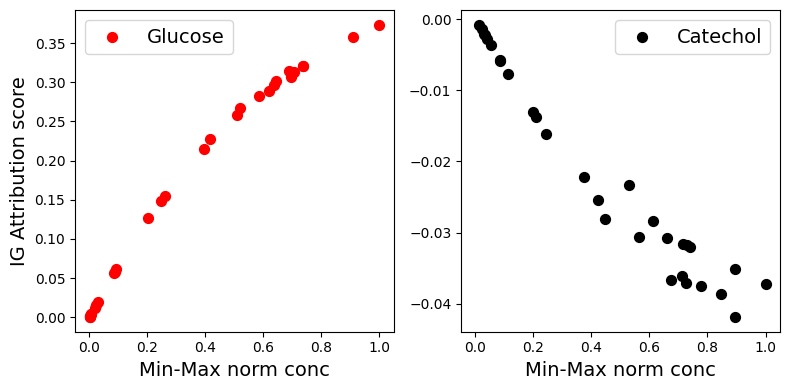

In [39]:
fig, axs = plt.subplots(1,2, figsize = (8,4), sharex = True)
ax = axs.ravel()
name = ["Glucose","Catechol"]
c = ["r", "k"]

for z in range(2):
    ax[z].scatter(x_temp[60:90,2*z+1], a[60:90,2*z+1], color = c[z], s = 50, label = name[z])
    ax[z].legend(fontsize = 14)
    ax[z].set_xlabel("Min-Max norm conc", fontsize = 14)
    if z == 0:
        ax[z].set_ylabel("IG Attribution score", fontsize = 14)
plt.tight_layout()

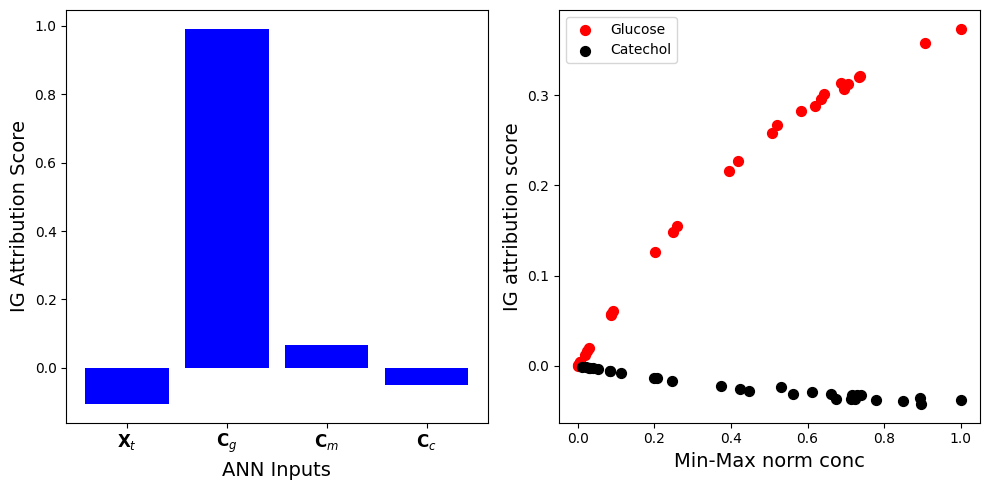

In [41]:
fig, axs = plt.subplots(1,2,figsize = (10,5))
ax = axs.ravel()

ax[0].bar(x, ig_norm, width = w, color = "b")
ax[0].set_ylabel("IG Attribution Score", fontsize = 14)
ax[0].set_xlabel("ANN Inputs", fontsize = 14)
ax[0].set_xticks(ticks = x, labels = ["X$_t$", "C$_g$","C$_m$","C$_c$"], fontsize = 12, fontweight = "bold")

ax[1].scatter(x_temp[60:90,1], a[60:90,1], s = 50, c = "r", label = "Glucose")
ax[1].scatter(x_temp[60:90,3], a[60:90,3], s = 50, c = "k", label = "Catechol")
ax[1].legend()
ax[1].set_xlabel("Min-Max norm conc", fontsize = 14)
ax[1].set_ylabel("IG attribution score", fontsize = 14)

plt.tight_layout()
plt.savefig("interpretability.svg")